# Using Twitter API and extracting the live tweet and analysis the sentimental 

## For the below detail  Reference taken from skillcate youtube video https://youtu.be/fQLa40L_BWA  

In [4]:
# bearer key: <key>
# api key: <key>
# api key secret :<key>
# access token: <key>
# access token secret : <key>
# client id : <key>
# client id secret:<key>

In [6]:
#importing the neccesary libraries
import tweepy
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\GK\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
#Put your Bearer Token in the parenthesis below
tweet=tweepy.Client(bearer_token="AAAAAAAAAAAAAAAAAAAAAEL3jQEAAAAAqHzTdrurr8FcccKr6FpHf5TGcGQ%3D6FYTE5wDytYTLmjxlOx3MPNoGXZBvWXBO8AYl61VDoiobpct4L")

# Pull tweets from twitter

In [8]:
query = '#apple -is:retweet lang:en'
paginator = tweepy.Paginator(
    tweet.search_recent_tweets,           # The method you want to use
    query=query,                           # Some argument for this method
    max_results=100,                       # How many tweets per page
    limit=100                               # How many pages to retrieve
)
# Get tweets that contain the hashtag #TypeKeywordHere
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english
tweet_list = []
for tweet in paginator.flatten(): # Total number of tweets to retrieve
    tweet_list.append(tweet)

In [9]:
#Creating new dataframe and new features
tweet_list_df = pd.DataFrame(tweet_list)
tweet_list_df = pd.DataFrame(tweet_list_df['text'])
tweet_list_df.head(5)

,text
0,Australia Win Series As Smith Misses Century \...
1,The Two&amp;Storey Apple Pacific Centre Store ...
2,#NowPlaying: Ground Zero - 9/27/22: KHOSTA 2 ...
3,Get Excited iphone Lovers! iphone 14 Pro Max w...
4,Content analysis:\nThis article scores 86/100....


In [10]:
def preprocess_tweet(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ", sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    return sentence

In [11]:
#cleaned tweet merging the data to the dataframe
cleaned_tweets = []
for tweet in tweet_list_df['text']:
    cleaned_tweet = preprocess_tweet(tweet)
    cleaned_tweets.append(cleaned_tweet)
tweet_list_df['cleaned'] = pd.DataFrame(cleaned_tweets)
tweet_list_df.head(5)

,text,cleaned
0,Australia Win Series As Smith Misses Century \...,australia win series as smith misses century s...
1,The Two&amp;Storey Apple Pacific Centre Store ...,the two amp storey apple pacific centre store ...
2,#NowPlaying: Ground Zero - 9/27/22: KHOSTA 2 ...,nowplaying ground zero 9 27 22 khosta 2 the d...
3,Get Excited iphone Lovers! iphone 14 Pro Max w...,get excited iphone lovers iphone 14 pro max wi...
4,Content analysis:\nThis article scores 86/100....,content analysis this article scores 86 100 th...


In [12]:
#Calculating Negative, Positive, Neutral and Compound values
tweet_list_df[['polarity', 'subjectivity']] = tweet_list_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list_df['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweet_list_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_list_df.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list_df.loc[index, 'sentiment'] = "neutral"
    tweet_list_df.loc[index, 'neg'] = neg
    tweet_list_df.loc[index, 'neu'] = neu
    tweet_list_df.loc[index, 'pos'] = pos
    tweet_list_df.loc[index, 'compound'] = comp

tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,Australia Win Series As Smith Misses Century \...,australia win series as smith misses century s...,0.800000,0.400000,positive,0.044,0.783,0.173,0.7650
1,The Two&amp;Storey Apple Pacific Centre Store ...,the two amp storey apple pacific centre store ...,0.151515,0.393939,positive,0.000,0.920,0.080,0.5267
2,#NowPlaying: Ground Zero - 9/27/22: KHOSTA 2 ...,nowplaying ground zero 9 27 22 khosta 2 the d...,0.000000,0.000000,negative,0.290,0.710,0.000,-0.8750
3,Get Excited iphone Lovers! iphone 14 Pro Max w...,get excited iphone lovers iphone 14 pro max wi...,0.375000,0.750000,positive,0.000,0.784,0.216,0.7003
4,Content analysis:\nThis article scores 86/100....,content analysis this article scores 86 100 th...,0.100000,0.400000,negative,0.140,0.860,0.000,-0.3818


# Model buliding 

In [13]:
tweet_prediction=tweet_list_df[["cleaned","sentiment"]]
tweet_prediction.head()

,cleaned,sentiment
0,australia win series as smith misses century s...,positive
1,the two amp storey apple pacific centre store ...,positive
2,nowplaying ground zero 9 27 22 khosta 2 the d...,negative
3,get excited iphone lovers iphone 14 pro max wi...,positive
4,content analysis this article scores 86 100 th...,negative


In [14]:
tweet_prediction["sentiment"].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [15]:
tweet_prediction["sentiment"].value_counts()

positive    4749
neutral     3647
negative    1593
Name: sentiment, dtype: int64

# Handling Categorical value using replace

In [16]:
tweet_prediction["sentiment"].replace({"neutral": 0, "positive": 1, "negative": -1},inplace=True)
tweet_prediction

C:\Users\GK\AppData\Local\Temp\ipykernel_1936\1407482369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_prediction["sentiment"].replace({"neutral": 0, "positive": 1, "negative": -1},inplace=True)


,cleaned,sentiment
0,australia win series as smith misses century s...,1
1,the two amp storey apple pacific centre store ...,1
2,nowplaying ground zero 9 27 22 khosta 2 the d...,-1
3,get excited iphone lovers iphone 14 pro max wi...,1
4,content analysis this article scores 86 100 th...,-1
...,...,...
9984,how to use linkedin for marketingstrategy mark...,0
9985,ios what specific odds for loot boxes are requ...,1
9986,13 m1 macbook air with 256gb sdd on sale for o...,0
9987,clearance 2020 10 9 inch ipad airs available s...,0


# Train_test_split

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(tweet_prediction.cleaned,tweet_prediction.sentiment,test_size=0.3)

# Handling categorical value using the countvectorizer

In [18]:
ct=CountVectorizer()
ct.fit(x_train)
x_train=ct.transform(x_train)
x_test=ct.transform(x_test)

# Model development using Multinomial naive bayes

In [19]:
model=MultinomialNB(alpha=0.0000000001)
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.7751084417751084

# Donut chart 

In [20]:
tweet_list_df_negative = tweet_list_df[tweet_list_df["sentiment"]=="negative"]
tweet_list_df_positive = tweet_list_df[tweet_list_df["sentiment"]=="positive"]
tweet_list_df_neutral = tweet_list_df[tweet_list_df["sentiment"]=="neutral"]

In [21]:
#Function for count_values_in single columns
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [22]:
#Count_values for sentiment
count_values_in_column(tweet_list_df,"sentiment")

,Total,Percentage
positive,4749,47.54
neutral,3647,36.51
negative,1593,15.95


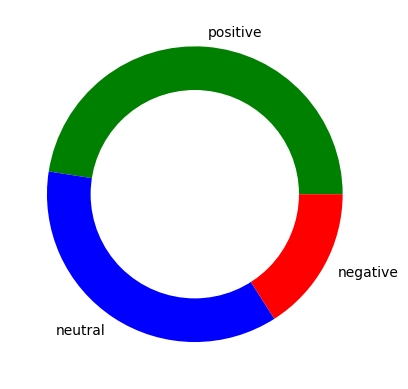

In [23]:
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")
# names= pc.index
# size=pc["Percentage"]

names= pichart.index
size=pichart["Percentage"]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Conclusion

## Since the tweet are in the postive manner so the people are loving the apple brand and the prediction is also pretty good 